# LA Metro Bike Share Cleaning, EDA, & Visualization

## Introduction
Imports

In [1]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import matplotlib

/Users/andretran/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Read the (nearly) cleaned csv file that contains our Metro Bike Share data.

In [2]:
trips_df = pd.read_csv("../Bike Share/2020-q1-cleaned.csv")
trips_df

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,stop_time,hour,start_station_name,end_station_name
0,134867493,25,2020-01-01 00:16:00,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,30,One Way,Monthly Pass,electric,2020-01-01 00:41:00,0,Olive & 5th,Main & Winston
1,134867799,35,2020-01-01 00:24:00,1/1/2020 0:59,4285,NaN,NaN,4354,34.017681,-118.409081,15661,1,One Way,One Day Pass,smart,2020-01-01 00:59:00,0,Not Found,Venice & Glendon
2,134868104,37,2020-01-01 00:31:00,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,1,One Way,Walk-up,smart,2020-01-01 01:08:00,0,Downtown Santa Monica Expo Line Station,Venice & Inglewood
3,134868103,36,2020-01-01 00:32:00,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,1,One Way,Walk-up,smart,2020-01-01 01:08:00,0,Downtown Santa Monica Expo Line Station,Venice & Inglewood
4,134868102,35,2020-01-01 00:33:00,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,1,One Way,Walk-up,smart,2020-01-01 01:08:00,0,Downtown Santa Monica Expo Line Station,Venice & Inglewood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76386,140275195,65,2020-03-31 22:48:00,3/31/2020 23:53,4460,33.994850,-118.417961,4460,33.994850,-118.417961,15300,30,Round Trip,Monthly Pass,smart,2020-03-31 23:53:00,22,Culver & Inglewood,Culver & Inglewood
76387,140274593,23,2020-03-31 23:00:00,3/31/2020 23:23,3076,34.040600,-118.253838,3031,34.044701,-118.252441,16811,30,One Way,Monthly Pass,electric,2020-03-31 23:23:00,23,9th & Los Angeles,Not Found
76388,140274893,14,2020-03-31 23:23:00,3/31/2020 23:37,3031,34.044701,-118.252441,3076,34.040600,-118.253838,16811,30,One Way,Monthly Pass,electric,2020-03-31 23:37:00,23,Not Found,9th & Los Angeles
76389,140275293,21,2020-03-31 23:37:00,3/31/2020 23:58,3076,34.040600,-118.253838,3056,34.037460,-118.265381,16811,30,One Way,Monthly Pass,electric,2020-03-31 23:58:00,23,9th & Los Angeles,Grand & 14th


Before moving on, I will remove all rows where the start or end latitude/longitude are null.

In [3]:
print(trips_df.isna().sum())
print(trips_df.dropna(inplace = True))
print(trips_df.isna().sum())

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station             0
start_lat              1145
start_lon              1145
end_station               0
end_lat                2723
end_lon                2723
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
bike_type                 0
stop_time                 0
hour                      0
start_station_name        0
end_station_name          0
dtype: int64
None
trip_id                0
duration               0
start_time             0
end_time               0
start_station          0
start_lat              0
start_lon              0
end_station            0
end_lat                0
end_lon                0
bike_id                0
plan_duration          0
trip_route_category    0
passholder_type        0
bike_type              0
stop_time              0
hour                   0
start_station_name     0


## EDA

In [4]:
trips_df["duration"].describe()

count    72955.000000
mean        20.853170
std         70.511138
min          1.000000
25%          6.000000
50%         11.000000
75%         19.000000
max       1440.000000
Name: duration, dtype: float64

Here I describe the duration, arguably the most important attribute.

The average ride is about 20 minutes. Furthermore, at least 75% of riders are riding at 19 minutes or less.

Below, I will create a new column distance which will calculate the distance between the start points and end points.

In [5]:
R = 3963

distance_df = pd.DataFrame(columns = ['distance'])
distance_df

for index, trip in trips_df.iterrows():
    lat1 = radians(trip["start_lat"])
    lon1 = radians(trip["start_lon"])
    lat2 = radians(trip["end_lat"])
    lon2 = radians(trip["end_lon"])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    new_item = {'distance' : distance}
    
    distance_df = distance_df.append(new_item, ignore_index=True)

distance_df

,distance
0,0.334849
1,3.612582
2,3.612582
3,3.612582
4,2.501893
...,...
72950,0.000000
72951,0.294739
72952,0.294739
72953,0.696335


In [6]:
# Get indexes for which column distance has value 0
indexZero = distance_df[ distance_df['distance'] == 0 ].index
# Delete these row indexes from dataFrame
distance_df.drop(indexZero , inplace=True)

distance_df.drop
distance_df.describe()

,distance
count,64027.000000
mean,0.870252
std,0.687405
min,0.066352
25%,0.425216
50%,0.665789
75%,1.112903
max,11.638144


I drop distances that are 0 (which means start and end points are equal) and I describe the data.

Here I can see the average ride is about 0.87 miles and 75% of riders ride 1.1 miles or less.

<AxesSubplot:>

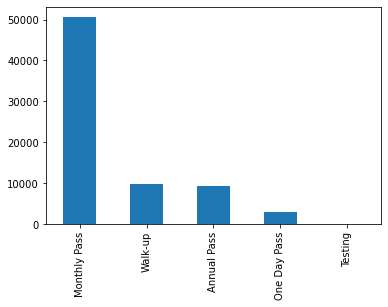

In [7]:
trips_df["passholder_type"].value_counts().plot.bar()

Above is a bar graph that shows the distribution of riders based on their passholder type. Monthly pass users outnumber all other types of users.

<AxesSubplot:>

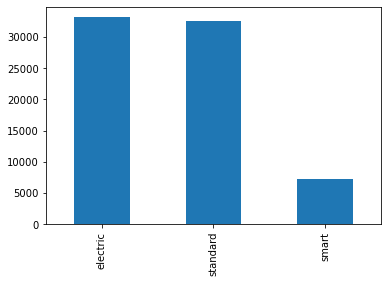

In [8]:
trips_df["bike_type"].value_counts().plot.bar()

Above is a bar graph that shows the distribution of bikes based on bike type. Interestingly, electric is the most popular type of bike.

<AxesSubplot:xlabel='passholder_type'>

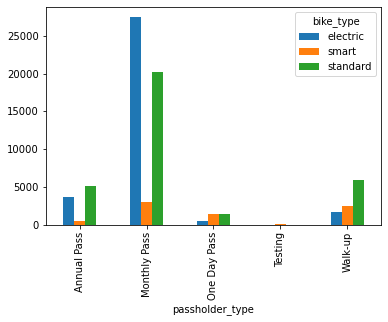

In [9]:
trips_df.groupby("passholder_type")["bike_type"].value_counts().unstack().plot.bar()

Here is another bar graph that shows the relationship between bike type and passholder. Monthly pass users rode electric bikes more often than others. This is likely due to the fact that monthly pass holders are more knowledgable/aware of electric bikes.

<AxesSubplot:xlabel='passholder_type'>

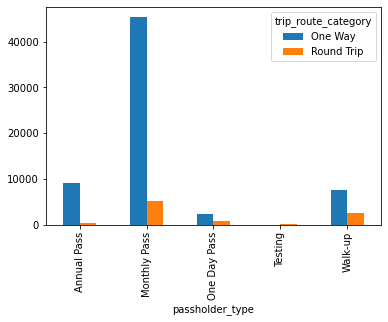

In [10]:
trips_df.groupby("passholder_type")["trip_route_category"].value_counts().unstack().plot.bar()

From the above graph, we can see that most trips are one way. This is understandable as many riders will likely pick up a different bike on their way back to their starting location.

<AxesSubplot:>

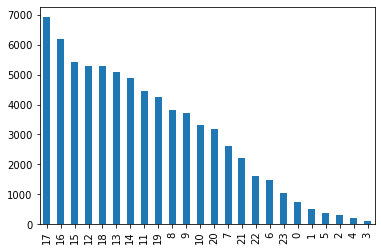

In [11]:
trips_df["hour"].value_counts().plot.bar()

The above graph shows number of trips per hour. 5PM is the busiest hour.

## Arrival/Departure Visualization
In this part, I will visualize the data and see what areas had more arrivals/departures within a specific hour.

The function below will collect the data from the trips_df for a specifc time (in this case 6am).

In [12]:
def get_trip_counts_by_hour (selected_hour):
    # select the first occurrence of each station id
    locations = trips_df.groupby("start_station").first()
    # and select only the three columns we are interested in
    locations = locations.loc[:, ["start_lat",
                                  "start_lon",
                                  "start_station_name"]]

    subset = trips_df[trips_df["hour"]==selected_hour]
    departure_counts =  subset.groupby("start_station").count()
    # select one column
    departure_counts = departure_counts.iloc[:,[0]]
    # and rename that column
    departure_counts.columns= ["Departure Count"]

    arrival_counts =  subset.groupby("end_station").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]
    
    
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    #Let's quickly remove any Nans
#     trip_counts.isna().sum()
#     trip_counts = trip_counts[trip_counts['start_lat'].notna()]
#     trip_counts = trip_counts[trip_counts['start_lon'].notna()]
    
    return trip_counts

#sample to check the function works
get_trip_counts_by_hour(6).head()

,Departure Count,start_lat,start_lon,start_station_name,Arrival Count
start_station,,,,,
3005,27,34.048500,-118.258537,7th & Flower,75.0
3006,2,34.045540,-118.256668,Olive & 8th,1.0
3007,3,34.050480,-118.254593,5th & Grand,29.0
3008,4,34.046612,-118.262733,Figueroa & 9th,8.0
3011,3,34.041130,-118.267982,Figueroa & Pico,4.0


The function below creates a map and will plot the bike data with circle markers to show departures/arrivals at a specific time. More departures and arrivals results in a bigger circle. Lastly, a tangerine (red) color means there were more departures, while a teal (blue) color means there were more arrivals.

In [13]:
def plot_station_counts(trip_counts):
    #Create our map of LA
    arrival_departure_map = folium.Map(location=[34.0522,-118.2437],
                                       zoom_start=11,
                                       tiles='CartoDB dark_matter')
    #Add a circle marker for each row
    for index, row in trip_counts.iterrows():
            net_departures = (row["Departure Count"]-row["Arrival Count"])
            total_departures = (row["Departure Count"]+row["Arrival Count"])
        
            #Popup message for each circle
            popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> total departures: {}"
            popup_text = popup_text.format(row["start_station_name"],
                                           row["Departure Count"],
                                           row["Arrival Count"],
                                           total_departures)
            
#             radius = np.abs(net_departures) / 5
            radius = total_departures / 5
            
            if net_departures>0:
                color="#E80018" # target red
            else:
                color="#81D8D0" # tiffany blue
            
            #Adds the marker to the map
            folium.CircleMarker(location=(row["start_lat"],
                                          row["start_lon"]),
                                radius=radius,
                                color=color,
                                popup=popup_text,
                                fill = True).add_to(arrival_departure_map)
        
    return arrival_departure_map

Map at 7 am

In [14]:
trip_counts = get_trip_counts_by_hour(7)
plot_station_counts(trip_counts)

9am

In [15]:
trip_counts = get_trip_counts_by_hour(9)
plot_station_counts(trip_counts)

12pm

In [16]:
trip_counts = get_trip_counts_by_hour(12)
plot_station_counts(trip_counts)

5pm (leaving work)

In [17]:
trip_counts = get_trip_counts_by_hour(17)
plot_station_counts(trip_counts)

8pm

In [18]:
trip_counts = get_trip_counts_by_hour(20)
plot_station_counts(trip_counts)

## Intensity Map Visualizations
Here I will connect the trips between the stations with a line and map them.

*Below is lots of code*

In [19]:
from PIL import ImageDraw, Image
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters

In [20]:
def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array

In [21]:
def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel = np.exp(-r/kernel_size/blur) + (1 - r/r[center,0]).clip(0)*halo
    return kernel

In [22]:
def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [1, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out

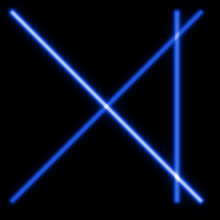

In [23]:
# generate some lines
xys = [(10,10,200,200), (175,10,175,200), (200,10,10,200)]  
weights = np.array([ 2,1,.7])/100  # some weights
# create the image_data
new_image_data = add_lines(np.zeros((220,220)),
                           xys,
                           width=4,
                           weights=weights)
# show the image
Image.fromarray(to_image(new_image_data),mode="RGBA")

In [24]:
min_lat = trips_df["start_lat"].min()
max_lat = trips_df["start_lat"].max()
max_lon = trips_df["start_lon"].max()
min_lon = trips_df["start_lon"].min()

def latlon_to_pixel(lat, lon, image_shape):
    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)

In [25]:
def row_to_pixel(row,image_shape):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["start_lat"], 
                                       row["start_lon"], image_shape)
    end_y, end_x = latlon_to_pixel(row["end_lat"], 
                                   row["end_lon"], image_shape)
    xy = (start_x, start_y, end_x, end_y)
    return xy

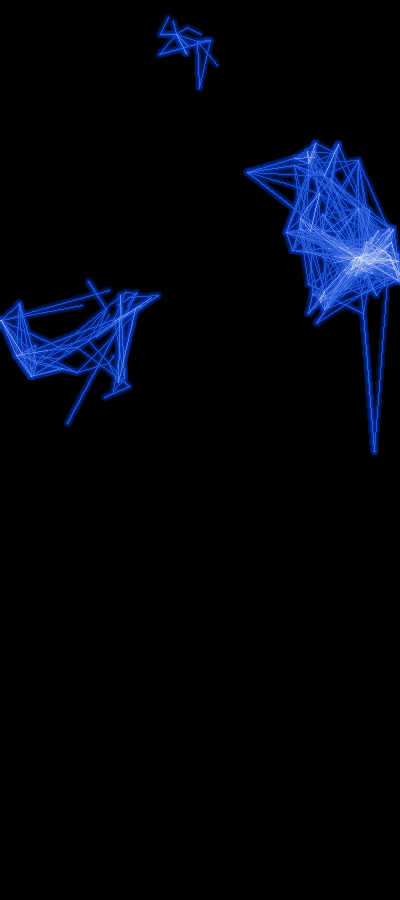

In [26]:
paths = trips_df[trips_df.hour==9]
paths = paths.iloc[:,:]
# generate empty pixel array, choose your resolution
image_data = np.zeros((900,400))
# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]
# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

In [27]:
# make a list of locations (latitude longitude) for each station id
locations = trips_df.groupby("start_station").mean()
locations = locations.loc[:,["start_lat", "start_lon"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
trips_df["path_id"] = [(id1,id2) for id1,id2 in zip(trips_df["start_station"], 
                                                     trips_df["end_station"])]
paths = trips_df[trips_df["hour"]==9].groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]>5]
paths["start_station"] = paths.index.map(lambda x:x[0])
paths["end_station"] = paths.index.map(lambda x:x[1])
paths = paths[paths["start_station"]!=paths["end_station"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="start_station")
locations.columns = ["end_lat","end_lon"]
paths = paths.join(locations,on="end_station")
paths.index = range(len(paths))

paths.shape

(101, 7)

In [28]:
def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((900*2,400*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data

In [29]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

*Continue here*

Below are all of the trips from start station to end station. Portions of the lines will get brighter as they intersect with other lines.

In [30]:
# create the map
folium_map = folium.Map(location=[34.0522,-118.2437],
                        zoom_start=11,
                        tiles="CartoDB dark_matter",
                        width='100%')

# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 1,
                           name = "Paths")

img.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# show the map
folium_map

Here is the complete collection map of the bikeshare system in Q1. The dowtown/central LA area has the most activity.

Below is a layered map that contains trips between 5 and 15, 15 and 25, and 25 and the max.

In [31]:
folium_map = folium.Map(location=[34.0522,-118.2437],
                        zoom_start=11,
                        tiles="CartoDB dark_matter",
                        width='100%')

thresholds = [5,15,25]

for i,t in enumerate(thresholds):
    upper = thresholds[i+1] if i<len(thresholds)-1 else None
    image_data = get_image_data(paths, t, upper)
    name = "{} < Num. Trips < {}".format(t,"max" if upper is None else upper)

    map_overlay = add_alpha(to_image(image_data*10))
    delta_lat = (max_lon-min_lon)/map_overlay.shape[1]*map_overlay.shape[0]*np.cos(min_lat/360*2*np.pi)
    img = folium.raster_layers.ImageOverlay(map_overlay,
                               bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                               name = name)

    img.add_to(folium_map)

lc = folium.LayerControl().add_to(folium_map)

folium_map

Unfortunately, many connections are now gone. This exemplifies that the LA Metro Bike Share is not the first option for riders, and it is not the everyday norm. If riders were recurring, we would see more lines from the previous image. Regardless, DTLA again has the most recurring riders.